In [85]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import FinancedfReader as fdr
warnings.filterwarnings('ignore') 

from tqdm import tqdm 
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta  

from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras import optimizers

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

ModuleNotFoundError: No module named 'FinancedfReader'

# 삼성전자 주가 예측

In [86]:
# 삼성전자 주식 가격 데이터 
df = fdr.DataReader('005930', '2016', '2022') # 2015-01-01 ~ 현재

In [87]:
# 데이터의 기초 통계량 확인
# 데이터의 요약 통계 정보를 제공하여 각 컬럼의 평균, 분산, 최솟값, 최댓값 등을 확인합니다.
df.describe()

,Open,High,Low,Close,Volume,Change
count,1475.000000,1475.000000,1475.000000,1475.000000,1.475000e+03,1475.000000
mean,50781.134237,51281.765424,50286.298305,50884.264407,1.004858e+07,0.000906
std,16202.147725,16330.897290,16056.403982,16002.430974,1.053082e+07,0.016548
min,0.000000,0.000000,0.000000,22520.000000,0.000000e+00,-0.080357
25%,42180.000000,42720.000000,41825.000000,42450.000000,2.483915e+05,-0.008573
50%,47980.000000,48400.000000,47380.000000,47960.000000,9.226097e+06,0.001017
75%,57350.000000,58000.000000,56500.000000,57210.000000,1.574836e+07,0.010189
max,90300.000000,96800.000000,89500.000000,91000.000000,9.030618e+07,0.104706


In [88]:
# 결측치 확인
# 결측치가 있는지 확인하여 데이터 전처리 필요성을 판단합니다.
print(df.isnull().sum())

Open      0
High      0
Low       0
Close     0
Volume    0
Change    0
dtype: int64


In [89]:
# 데이터 타입 확인
# 데이터 타입이 적절한지 확인하여 필요시 변환을 진행할 수 있습니다.
print(df.dtypes)

Open        int64
High        int64
Low         int64
Close       int64
Volume      int64
Change    float64
dtype: object


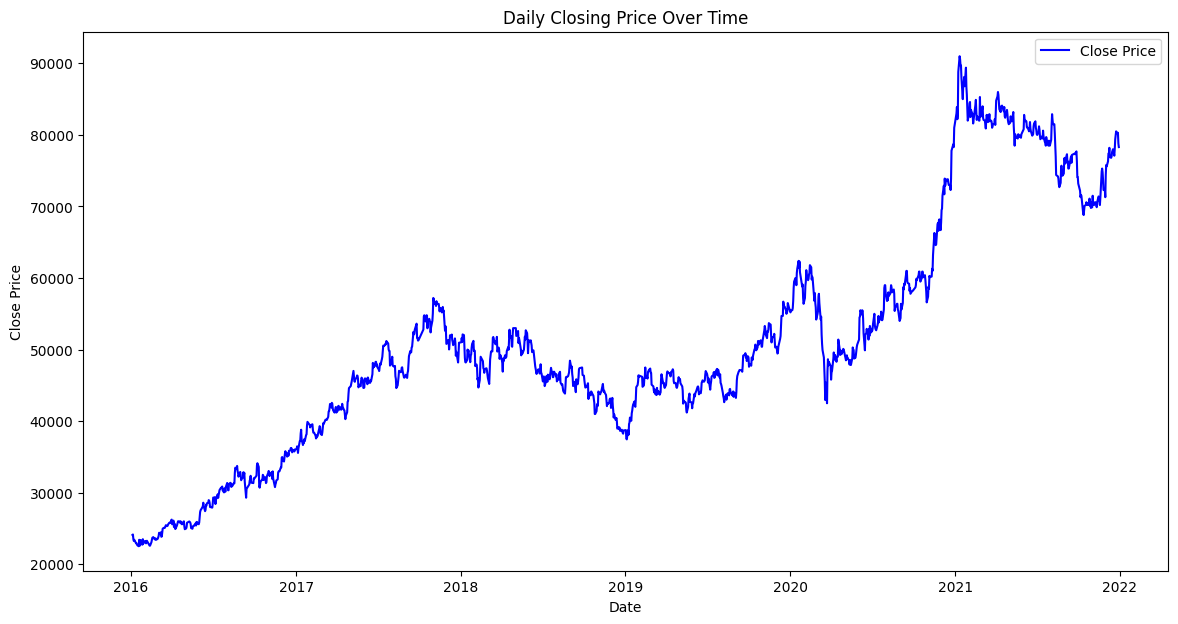

In [90]:
# 시계열 데이터의 일자별 종가 시각화
# 시간에 따른 주가의 변동을 시각적으로 확인하기 위해 라인 플롯을 사용합니다.
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Close'], label='Close Price', color='b')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Daily Closing Price Over Time')
plt.legend()
plt.show()

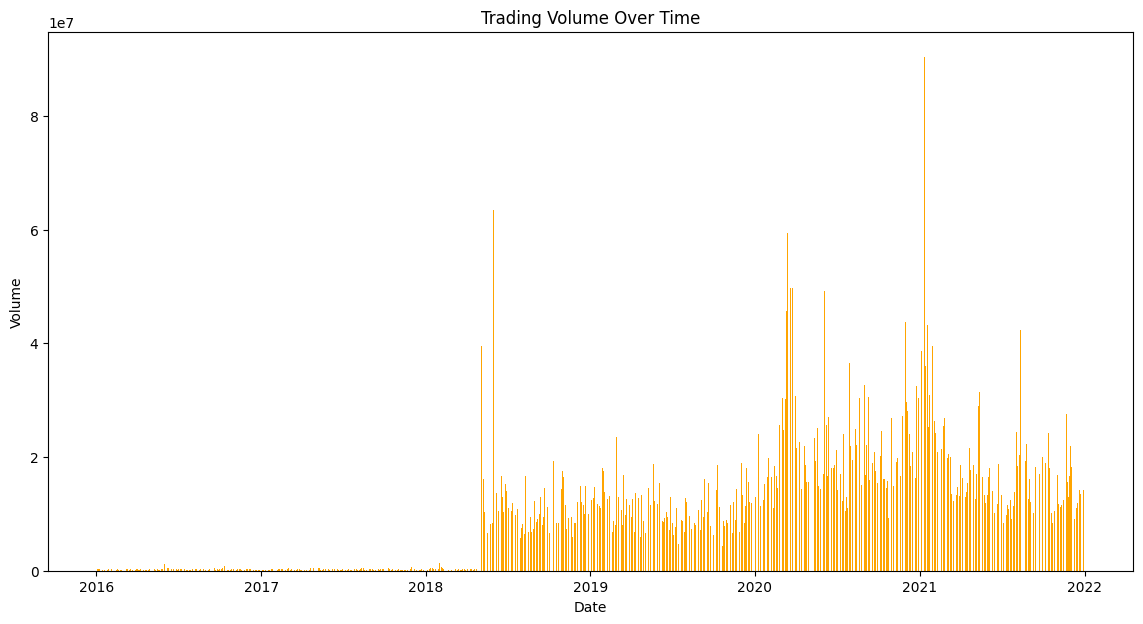

In [91]:
# 거래량 시각화
# 거래량이 많았던 날을 파악하기 위해 바 차트를 사용하여 거래량 변화를 시각화합니다.
plt.figure(figsize=(14, 7))
plt.bar(df.index, df['Volume'], color='orange')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.title('Trading Volume Over Time')
plt.show()


            Open      High       Low     Close    Volume
Open    1.000000  0.999434  0.999613  0.988054  0.586292
High    0.999434  1.000000  0.999413  0.988569  0.595014
Low     0.999613  0.999413  1.000000  0.988615  0.580611
Close   0.988054  0.988569  0.988615  1.000000  0.586560
Volume  0.586292  0.595014  0.580611  0.586560  1.000000


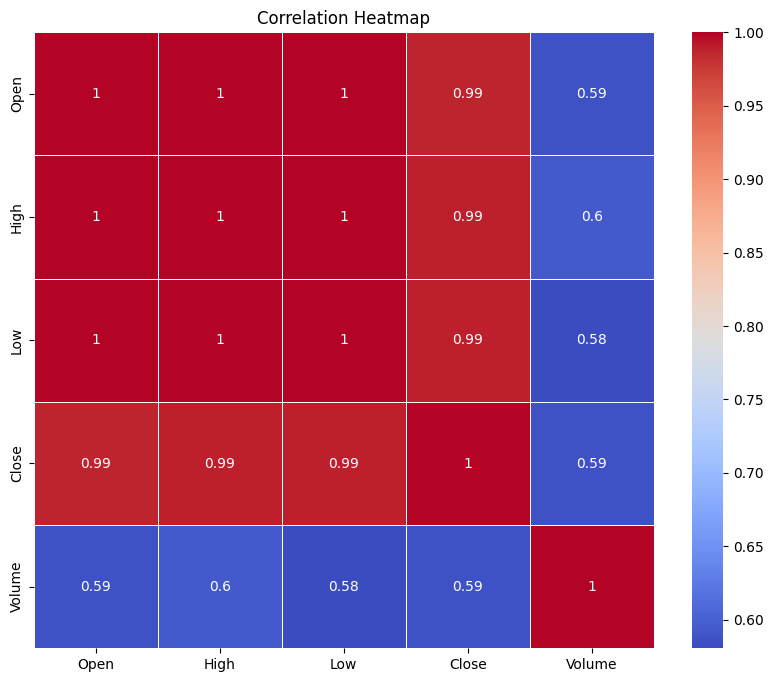

In [92]:
# 상관 관계 분석
# 각 컬럼 간의 상관관계를 분석하여 변수 간의 연관성을 파악합니다.
corr_matrix = df[['Open', 'High', 'Low', 'Close', 'Volume']].corr()
print(corr_matrix)

# 상관 관계 히트맵 시각화
# 상관관계 히트맵을 그려서 데이터 간의 상관도를 쉽게 확인할 수 있습니다.
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

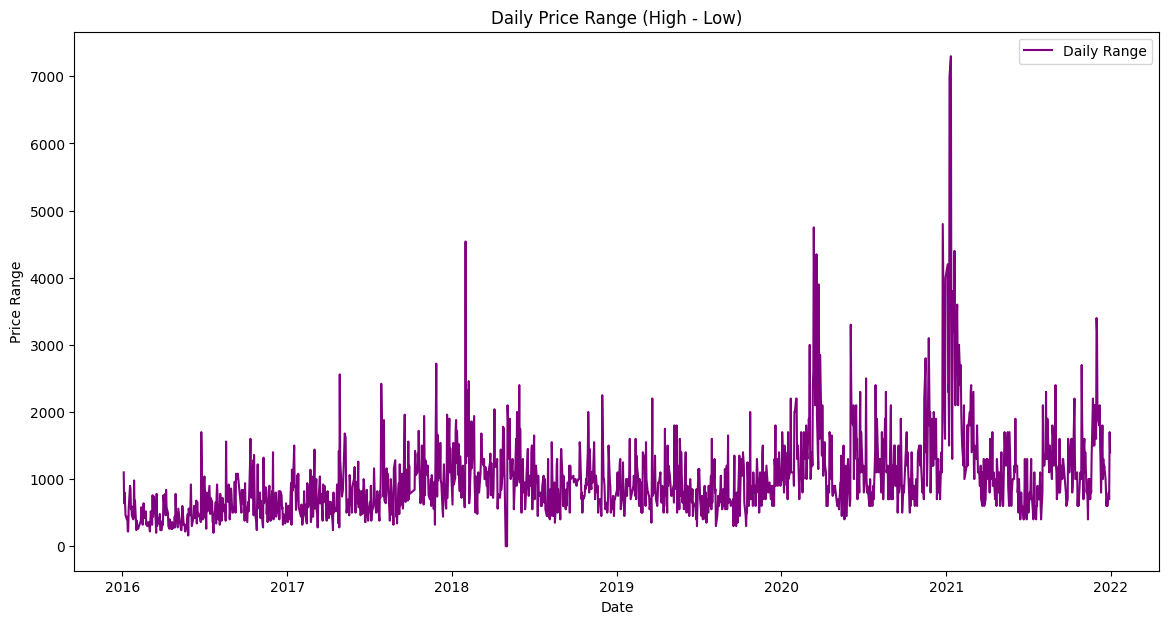

In [93]:
# 일간 변동폭 시각화 (High - Low)
# 하루 동안의 변동폭을 계산하여 시각화합니다.
df['Daily Range'] = df['High'] - df['Low']
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Daily Range'], label='Daily Range', color='purple')
plt.xlabel('Date')
plt.ylabel('Price Range')
plt.title('Daily Price Range (High - Low)')
plt.legend()
plt.show()

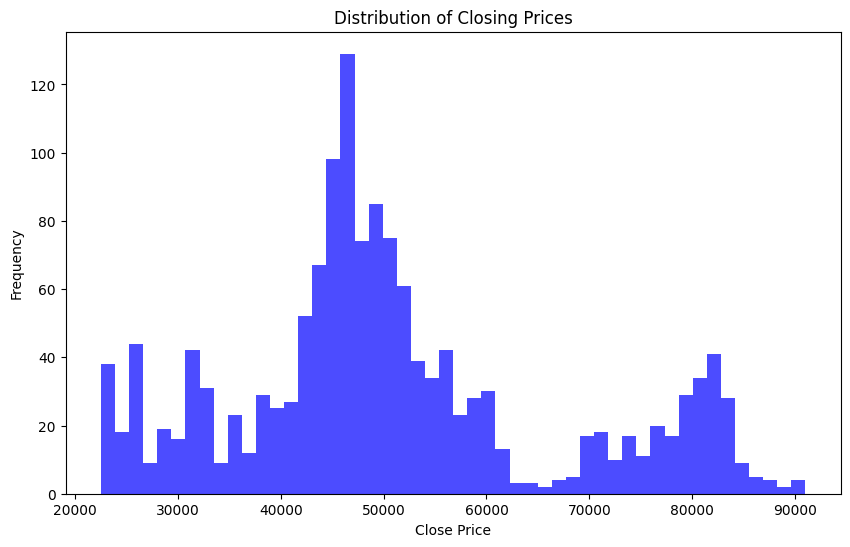

In [94]:
# 종가의 분포 확인 (히스토그램)
# 종가의 분포를 히스토그램을 통해 확인하여 데이터의 분포 형태를 파악합니다.
plt.figure(figsize=(10, 6))
plt.hist(df['Close'], bins=50, color='blue', alpha=0.7)
plt.xlabel('Close Price')
plt.ylabel('Frequency')
plt.title('Distribution of Closing Prices')
plt.show()

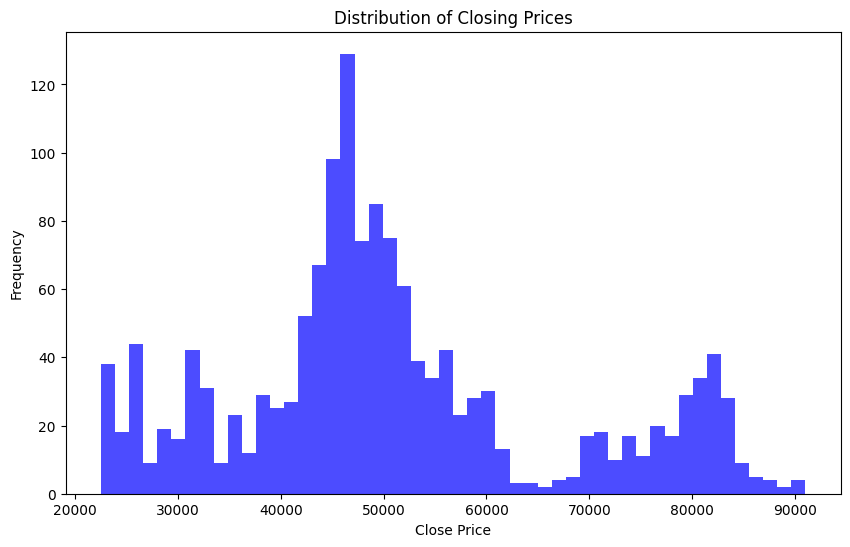

In [95]:
# 종가의 분포 확인 (히스토그램)
# 종가의 분포를 히스토그램을 통해 확인하여 데이터의 분포 형태를 파악합니다.
plt.figure(figsize=(10, 6))
plt.hist(df['Close'], bins=50, color='blue', alpha=0.7)
plt.xlabel('Close Price')
plt.ylabel('Frequency')
plt.title('Distribution of Closing Prices')
plt.show()

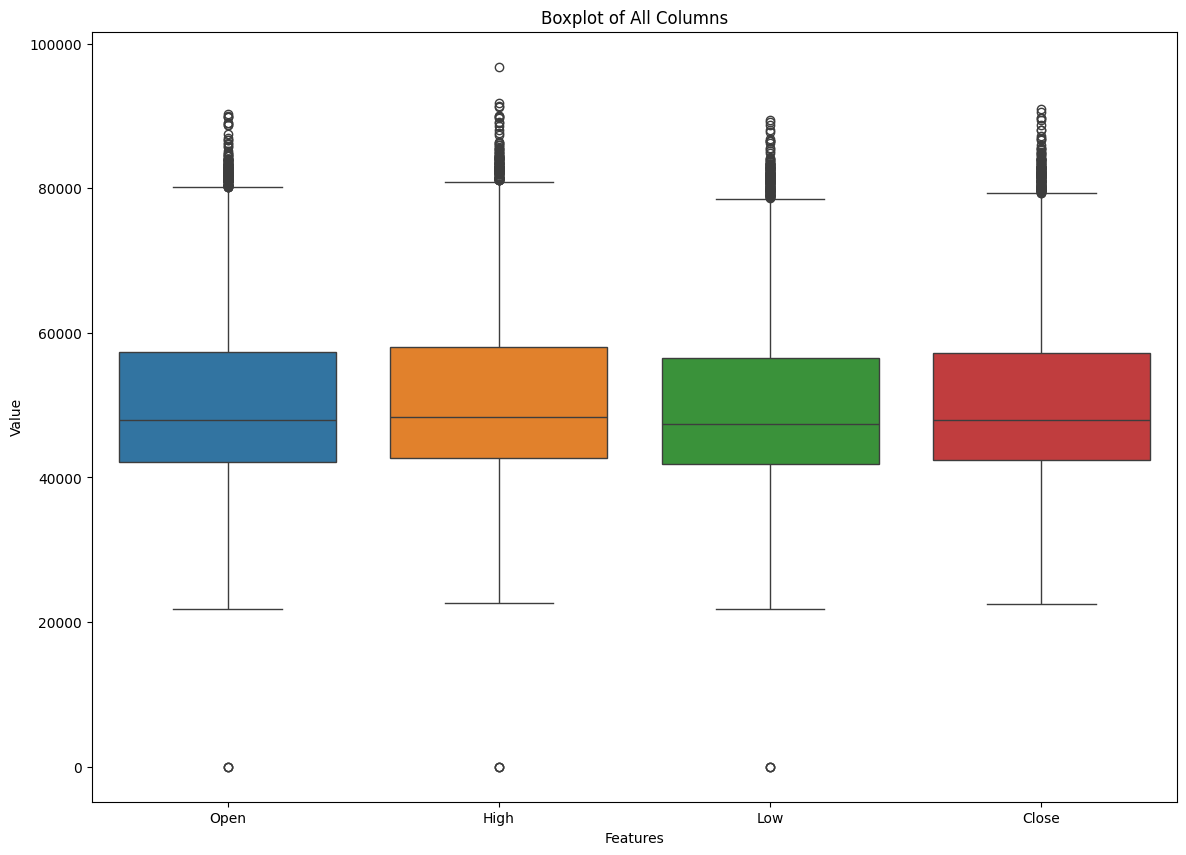

In [96]:
# 모든 컬럼에 대해 박스플롯 시각화
# 각 컬럼의 분포와 이상치를 한눈에 파악하기 위해 모든 컬럼에 대해 박스플롯을 그립니다.
plt.figure(figsize=(14, 10))
sns.boxplot(data=df[['Open', 'High', 'Low', 'Close']])
plt.title('Boxplot of All Columns')
plt.xlabel('Features')
plt.ylabel('Value')
plt.show()

In [104]:
df = df[df['Open'] != 0]

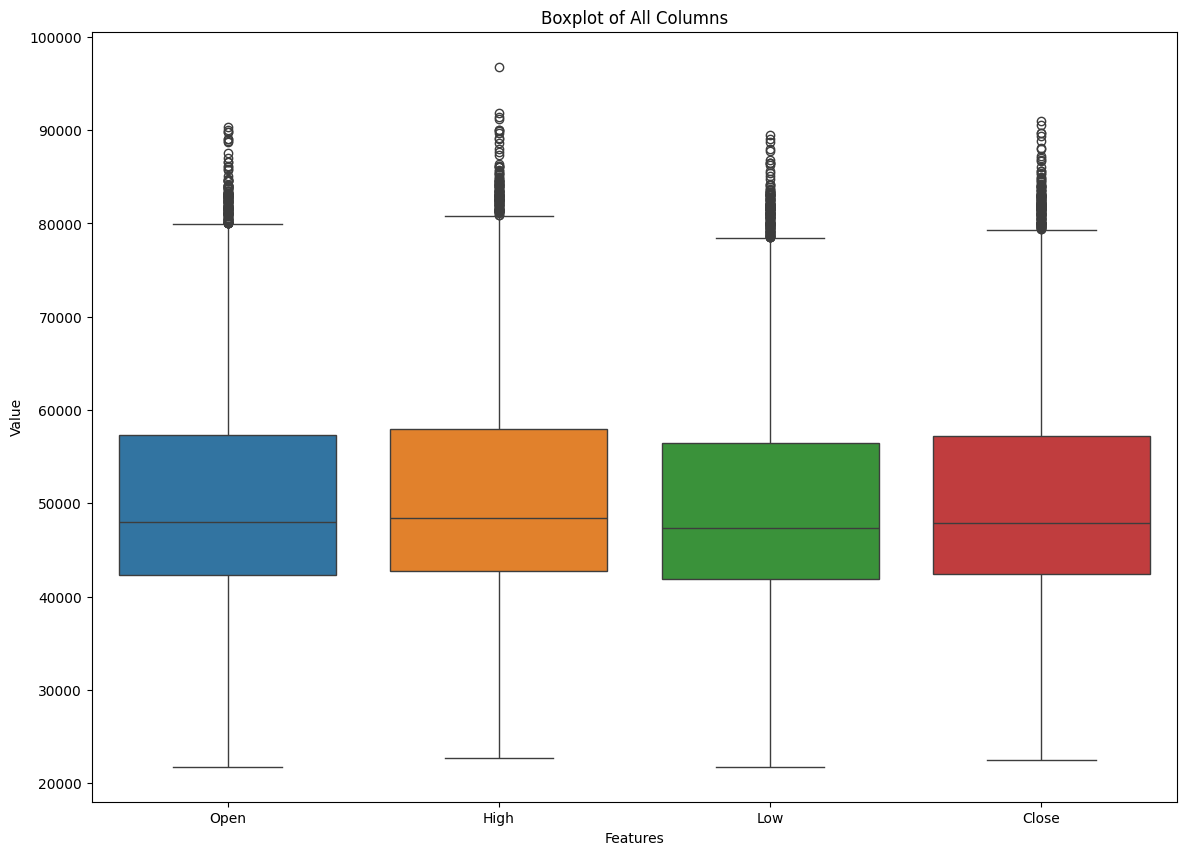

In [105]:
# 모든 컬럼에 대해 박스플롯 시각화
# 각 컬럼의 분포와 이상치를 한눈에 파악하기 위해 모든 컬럼에 대해 박스플롯을 그립니다.
plt.figure(figsize=(14, 10))
sns.boxplot(data=df[['Open', 'High', 'Low', 'Close']])
plt.title('Boxplot of All Columns')
plt.xlabel('Features')
plt.ylabel('Value')
plt.show()

In [97]:
# 종가의 등락을 예측하기 위해 목표 변수 설정
df['Target'] = (df['Close'].shift(-1) > df['Close']).astype(int)
df = df[:-1]
features = df[['Open', 'High', 'Low', 'Close', 'Volume']]
labels = df['Target']

In [98]:
# 데이터 정규화
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

# 시계열 데이터 윈도우 생성
def create_windowed_df(features, labels, window_size):
    X, y = [], []
    for i in range(len(features) - window_size):
        X.append(features[i:i + window_size])
        y.append(labels[i + window_size])
    return np.array(X), np.array(y)

window_size = 15
x, y = create_windowed_df(features_scaled, labels, window_size)

In [99]:
# 학습, 검증, 테스트 데이터 분할
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.2, shuffle=False)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, shuffle=False)

In [100]:
initializer = tf.keras.initializers.GlorotUniform()
def create_model(step_in, features):
    model = Sequential()
    model.add(LSTM(16, activation='relu', return_sequences=True, input_shape=(step_in, features),kernel_initializer=initializer))
    model.add(Dropout(0.2))
    model.add(LSTM(8, activation='relu', return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(optimizer=optimizers.Adam(learning_rate= 0.002, name="Adam"), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [101]:

earlystop_callback = EarlyStopping(monitor='val_accuracy', mode='auto', min_delta=0.001, patience=30)
model = create_model(x_train.shape[1], x_train.shape[2])
history = model.fit(x_train,y_train,
                    epochs=1000, batch_size=50, verbose=1,
            validation_data = (x_val, y_val), callbacks=[earlystop_callback])

Epoch 1/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.5098 - loss: 0.6931 - val_accuracy: 0.4795 - val_loss: 0.6957
Epoch 2/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5180 - loss: 0.6917 - val_accuracy: 0.4795 - val_loss: 0.6949
Epoch 3/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5181 - loss: 0.6920 - val_accuracy: 0.4795 - val_loss: 0.6947
Epoch 4/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5259 - loss: 0.6933 - val_accuracy: 0.4795 - val_loss: 0.6947
Epoch 5/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5185 - loss: 0.6924 - val_accuracy: 0.4795 - val_loss: 0.6930
Epoch 6/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5319 - loss: 0.6876 - val_accuracy: 0.5274 - val_loss: 0.6925
Epoch 7/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5183 - loss: 0.6916 - val_accuracy: 0.5822 - val_loss: 0.6928
Epoch 8/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5305 - loss: 0.6904 - val_accuracy: 0

In [102]:
pred = model.predict(x_test) 
print('정확도: %.4f' %accuracy_score(y_test, pred.round().reshape(-1)))
print('precision: %.4f' %precision_score(y_test, pred.round().reshape(-1), average='binary'))
print('recall: %.4f' %recall_score(y_test, pred.round().reshape(-1), average='binary'))  
print('f1_score: %.4f' %f1_score(y_test, pred.round().reshape(-1), average='binary'))
print('confusion_matrix',confusion_matrix(pred.round().reshape(-1), y_test) )

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
정확도: 0.5548
precision: 0.0000
recall: 0.0000
f1_score: 0.0000
confusion_matrix [[81 65]
 [ 0  0]]


# 도전 과제 : 가격의 등락이 아닌 가격 자체를 예측하는 모델링을 수행해보세요